In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [362]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, precision_recall_curve

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer as Imputer

from sklearn.pipeline import Pipeline

In [81]:
def dropthenan(table):
    cond1 = table[table.cfbconference == 'Other'].index.tolist()
    cond2 = table[table.cfbtd.isna()].index.tolist()
    cond3 = table[table.combineforty.isna()].index.tolist()
#    cond = np.unique(cond1+cond2+cond3)
    cond = np.intersect1d(np.intersect1d(cond1,cond2),cond3)
    return table.drop(cond, axis = 0).reset_index(drop = True)

def confclass(table):
    table.loc[table.cfbconference == 'Other','cfbconference'] = np.nan
    table.loc[table.cfbclass == 'Non Declared','cfbclass'] = np.nan
    table = pd.get_dummies(table, prefix=['cfbconference','cfbclass'])
    return table

# def splitter(table, col, thresh):
#     table['target'] = table[col].apply(lambda x: 1 if x > thresh else 0)
#     return table.drop(col, axis = 1)

def splitter(arr, thresh):
    return arr.apply(lambda x: 1 if x > thresh else 0)

def normalizeX(X, cols_list):
    x = X[cols_list]
    X_others = X.drop(cols_list, axis = 1)
    trans = preprocessing.MinMaxScaler()
    #trans = preprocessing.StandardScaler()
    x_scaled = trans.fit_transform(x)
    X_new = pd.DataFrame(x_scaled , columns = X[cols_list].columns.tolist())
    return pd.concat([X_new, X_others], axis = 1) #pd.concat([X_new + X_others], axis = 1)

In [6]:
colsnum = ['cfbgames','cfbreceptions','cfbrecyards','cfbrecyardsperreception','cfbrectd',
           'cfbrushattempts','cfbrushyards','cfbrushyardsperattempt','cfbrushtd','cfbscrimmages',
           'cfbyards','cfbyardsfromscrimmage','cfbtd','combineht','combinewt','combineforty',
           'combinevertical','combinebroadjump','combinecone','combineshuttle']

wr = pd.read_csv('data_sets/wr.csv')
wr = wr.rename(columns = {'yardsfirst5seasons': 'yffs'})
wr = wr.drop('combinebenchreps', axis = 1)

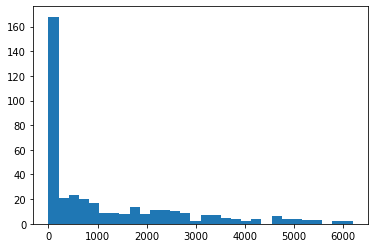

In [225]:
plt.hist(wrp.yffs, bins = 30)
plt.show()

# At a fixed threshold y < or > 50

In [183]:
wr1 = dropthenan(wr)
wr1 = confclass(wr1)

In [408]:
X = wr1.drop('yffs', axis = 1)
y = wr1.yffs

imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)
X = pd.DataFrame(X, columns = wr1.drop('yffs', axis = 1).columns.tolist())

X = normalizeX(X, colsnum)
y = splitter(y, 50)

### KNeighbors Classifier on a random train/test split data

In [409]:
knn = KNeighborsClassifier(n_neighbors = 18)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print('score',knn.score(X_test, y_test))
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

score 0.6964285714285714
              precision    recall  f1-score   support

           0       0.29      0.06      0.11        31
           1       0.72      0.94      0.82        81

    accuracy                           0.70       112
   macro avg       0.50      0.50      0.46       112
weighted avg       0.60      0.70      0.62       112



### Logistic Regression on a random train/test split data

In [85]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y)

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 5 26]
 [ 5 76]]
              precision    recall  f1-score   support

           0       0.50      0.16      0.24        31
           1       0.75      0.94      0.83        81

    accuracy                           0.72       112
   macro avg       0.62      0.55      0.54       112
weighted avg       0.68      0.72      0.67       112



### ROC Curve (varying threshold p) on a random train/test split data: TPR and FPR

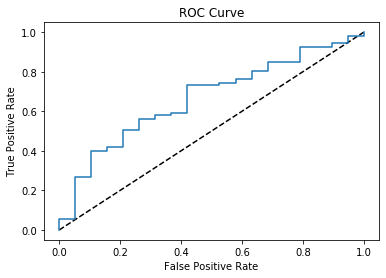

0.6644029428409733
0.48720707579041733


In [364]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

logreg.fit(X_train,y_train)

y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print(roc_auc_score(y_test, y_pred_prob))
print(log_loss(y_test, y_pred_prob))

For each value predicted, we return the tpr and fpr depending on the threshold. Those are defined in the two cells below.

In [360]:
j = 3 
tpr[j], fpr[j], thresholds[j]

(0.02531645569620253, 0.030303030303030304, 0.9090571442909853)

In [359]:
mat = np.transpose([y_pred_prob,y_pred,y_test])

tp = [1 for i in range(len(mat)) if mat[i,0] >= thresholds[j] and mat[i,2] == 1]
tn = [1 for i in range(len(mat)) if mat[i,0] < thresholds[j] and mat[i,2] == 0]
fp = [1 for i in range(len(mat)) if mat[i,0] >= thresholds[j] and mat[i,2] == 0]
fn = [1 for i in range(len(mat)) if mat[i,0] < thresholds[j] and mat[i,2] == 1]

len(tp) / (len(tp) + len(fn)), len(fp) / (len(fp) + len(tn))

(0.02531645569620253, 0.030303030303030304)

### ROC Curve (varying threshold p) on a random train/test split data: Recall vs Precision

We're actually interested in precision and recall with respect to the 'flops' , those that are below the threshold. Particuarly the recall, since we want our model to produce as least as possible as false negatives, those that are flops but that the model fails to capture.

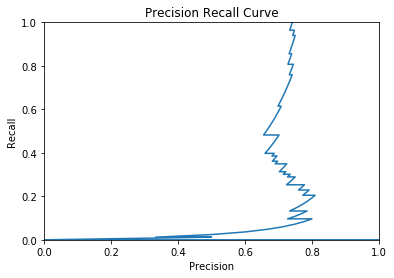

In [403]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

logreg.fit(X_train,y_train)
y_pred_prob = logreg.predict_proba(X_test)[:,0]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.show()

### Using a Pipeline to for Hyperparameter tuning on
- a Logisitic Regressor
- a K-Neighbors Classifier
- a Random Forest Classifier

In [458]:
y_new = [(lambda u: 0 if u > 0 else 1)(u) for u in y]

pipeline = Pipeline([ ('classifier' , RandomForestClassifier())
                    ])

param_grid = [
    {'classifier': [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-5, 8, 15),
    'classifier__solver' : ['liblinear']},
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': np.arange(1,50)},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
    ]

# param_grid =  {'classifier' : [RandomForestClassifier()],
#     'classifier__class_weight': ['balanced'],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}

clf = GridSearchCV(pipeline, param_grid = param_grid, scoring = 'recall', cv = 5)#, verbose=True, n_jobs=-1)

best_clf = clf.fit(X, y_new)

In [459]:
#print(best_clf)
print("Best params", best_clf.best_params_)
print("Best score", best_clf.best_score_)
#for param_name in sorted(param_grid[1].keys()):
#    print("%s: %s" %(param_name, best_clf.best_params_[param_name]))

Best params {'classifier': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'), 'classifier__n_neighbors': 1}
Best score 0.439047619047619


In [460]:
#clf = RandomForestClassifier( max_features= 6, n_estimators= 100, class_weight= 'balanced', random_state= 32)
#clf = LogisticRegression(C = 1e-05, penalty= 'l2', solver ='liblinear')
clf = KNeighborsClassifier(n_neighbors=1)

In [468]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

print(y_test.value_counts(),'\n', pd.DataFrame(y_pred)[0].value_counts())

[[14 18]
 [25 55]]
              precision    recall  f1-score   support

           0       0.36      0.44      0.39        32
           1       0.75      0.69      0.72        80

    accuracy                           0.62       112
   macro avg       0.56      0.56      0.56       112
weighted avg       0.64      0.62      0.63       112

1    80
0    32
Name: yffs, dtype: int64 
 1    73
0    39
Name: 0, dtype: int64


In [410]:
# param_grid = {'C': np.logspace(-5, 8, 15),'penalty': ['l1', 'l2']}
# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(logreg, param_grid, cv=5, verbose=0)
# logreg_cv.fit(X, y)
# print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
# print("Best score is {}".format(logreg_cv.best_score_))
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])

# param_grid = {'n_neighbors':np.arange(1, 50)}
# knn = KNeighborsClassifier()
# knn_cv = GridSearchCV(knn, param_grid, cv = 10)
# knn_cv.fit(X, y)
# print(knn_cv.best_params_)
# print(knn_cv.best_score_)

# Varying Threshold of Acceptance

In [30]:
wr2 = dropthenan(wr)
wr2 = confclass(wr2)
X = wr2.drop('yffs', axis = 1)

imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)
X = pd.DataFrame(X, columns = wr1.drop('yffs', axis = 1).columns.tolist())

X = normalizeX(X, colsnum)
#y = wr2.yffs
#y = splitter(y, 50)

# Building the two models

In [496]:
param_grid = {'alpha': np.logspace(-4, 0, 50)}
ridge = Ridge(normalize = True)

def ridgefit(wrtf, threshf, option):
    if option == 'low':
        wrtf = wrtf[wrtf.yffs<threshf]
    elif option == 'high':
        wrtf = wrtf[wrtf.yffs>threshf]
    
    X = wrtf.drop('yffs', axis = 1)
    y = wrtf.yffs
    
    imp = Imputer(missing_values= np.nan, strategy = 'mean')
    imp.fit(X)
    X = imp.transform(X)
    X = pd.DataFrame(X, columns = wrtf.drop('yffs', axis = 1).columns.tolist())
    X = normalizeX(X, colsnum)

    reg_cv = GridSearchCV(ridge, param_grid, cv=10, scoring= 'neg_root_mean_squared_error')
    reg_cv = GridSearchCV(ridge, param_grid, cv=10)
    reg_cv.fit(X, y)
    
    return reg_cv.best_params_, reg_cv.best_score_

In [546]:
np.log(wrt[wrt.yffs>1].yffs)

0      8.727616
1      8.732466
2      6.408529
3      6.897705
4      8.355615
         ...   
364    6.511745
365    4.262680
367    6.016157
370    2.397895
371    6.690842
Name: yffs, Length: 301, dtype: float64

In [549]:
np.log(8000)

8.987196820661973

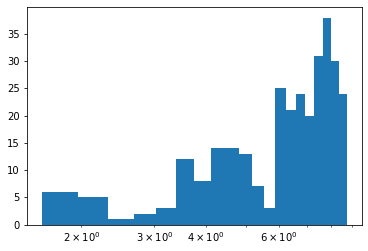

In [543]:
plt.hist(np.log(wrt[wrt.yffs>1].yffs), bins = 20)
plt.xscale('log')

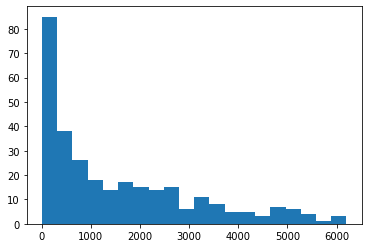

In [545]:
plt.hist(wrt[wrt.yffs>1].yffs, bins = 20)
plt.show()

In [503]:
wrt = dropthenan(wr)
wrt = confclass(wrt)
low_list = []
high_list = []
thresh_space = np.arange(1, 200, 10) 

for thresh in thresh_space:
    low_list.append(ridgefit(wrt, thresh, 'low'))
    high_list.append(ridgefit(wrt, thresh, 'high'))

In [526]:
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))

pd.DataFrame({'thresh':thresh_space, 
              'alpha_low': [ low_list[i][0]['alpha'] for i in range(len(low_list)) ], 
              'cv_score_low': [ low_list[i][1] for i in range(len(low_list)) ],
              'alpha_high': [ high_list[i][0]['alpha'] for i in range(len(high_list)) ], 
              'cv_score_high': [high_list[i][1] for i in range(len(high_list)) ]              
             })

,thresh,alpha_low,cv_score_low,alpha_high,cv_score_high
0,1,0.0001,-0.016667,0.828643,0.125969
1,11,1.0000,-0.182560,0.828643,0.116178
2,21,1.0000,-0.164092,0.828643,0.112290
3,31,1.0000,-0.916822,1.000000,0.113091
4,41,1.0000,-0.190631,1.000000,0.094551
5,51,1.0000,-0.182715,1.000000,0.096321
6,61,1.0000,-0.403156,1.000000,0.072376
7,71,1.0000,-0.384613,1.000000,0.074265
8,81,1.0000,-0.285651,1.000000,0.073223
9,91,1.0000,-0.355385,0.828643,0.063739


In [ ]:
#ridge_rmse = []
# for alpha in alpha_space:
#     ridge.alpha = alpha   
#     ridge_cv_scores = cross_validate(ridge, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))   
#     ridge_rmse.append(-np.mean(ridge_cv_scores['test_neg_root_mean_squared_error']))
    
# plt.plot(alpha_space, ridge_rmse)
# plt.xscale("log")
# plt.xlabel("Alpha")
# plt.ylabel('Root Mean Square Error')
# plt.axvline(alpha_best, linestyle = '--')
# plt.axhline(-reg_cv.best_score_, linestyle = '--')
# plt.show()

### With a KNeighbors Classifier

In [31]:
param_grid = {'n_neighbors':np.arange(1,30)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 10)

bp_list=[]
bs_list=[]

for thresh in np.arange(1,100,5):
    y = wr2.yffs
    y = splitter(y, thresh)
    knn_cv.fit(X, y)
    bp_list.append(knn_cv.best_params_)
    bs_list.append(knn_cv.best_score_)